In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import cdist
from math import pi

In [2]:
# Chemin vers le fichier GZIP
gzip_file_path = "C:/Users/HanSAriEle/OneDrives/Desktop/PROJET_TUTORE/database_quality_ofair.csv.gz"

# Lire le fichier CSV directement depuis le fichier GZIP
data = pd.read_csv(gzip_file_path, compression='gzip')

# Afficher les premières lignes du DataFrame pour vérifier
data.head()

,Date,City,Country_Name,Continent,aqi,co,neph,no2,o3,pm10,pm25,so2,Categorie
0,2019-01-01,Addis Ababa,Ethiopia,Africa,38.0,1.933333,23.333333,7.333333,16.533333,15.333333,38.000000,1.266667,Bon
1,2019-01-01,Adelaide,Australia,Oceania,7.0,0.100000,3.666667,0.100000,0.000000,7.000000,6.000000,0.100000,Bon
2,2019-01-01,Barcelona,Spain,Europe,27.0,0.100000,9.666667,17.000000,4.900000,27.000000,27.666667,4.600000,Bon
3,2019-01-01,Bilbao,Spain,Europe,68.0,0.100000,39.000000,12.800000,3.300000,23.000000,68.000000,4.000000,Modéré
4,2019-01-01,Bogotá,Colombia,South America,34.0,4.600000,8.666667,2.300000,8.300000,17.000000,34.000000,0.300000,Bon


**CLUSTERING PAR PAYS**

In [3]:
# Sélectionner uniquement les colonnes numériques pour l'agrégation
numeric_columns = ['aqi', 'co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']
non_numeric_columns = ['City', 'Country_Name', 'Continent']

# Vérifier que les colonnes sélectionnées existent dans les données
for col in numeric_columns:
    if col not in data.columns:
        print(f"Warning: {col} not found in data columns")


# Agréger les données par ville (en utilisant les colonnes numériques)
agg_data_numeric = data.groupby('Country_Name')[numeric_columns].mean().reset_index()

# Conserver les informations non numériques pour les premières occurrences
agg_data_non_numeric = data[non_numeric_columns].drop_duplicates(subset=['Country_Name']).reset_index(drop=True)

# Combiner les données agrégées avec les informations non numériques
agg_data = pd.merge(agg_data_non_numeric, agg_data_numeric, on='Country_Name')


# Standardiser les données
X = agg_data[numeric_columns]
scaler = StandardScaler()
df_normalized = scaler.fit_transform(X)

# ACP
pca = PCA()
df_pca = pca.fit_transform(df_normalized)

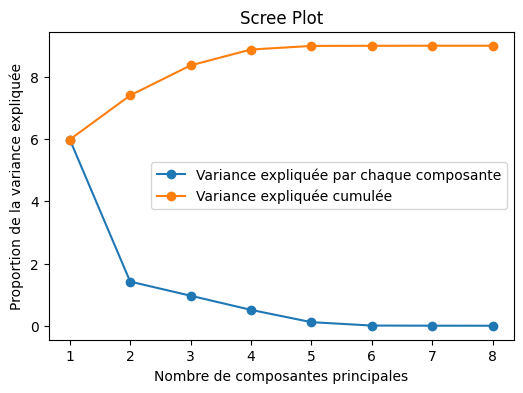

In [4]:
# Calculer la variance expliquée cumulée
explained_variance = pca.explained_variance_

cumulative_explained_variance = np.cumsum(explained_variance)

# Créer un scree plot avec la variance expliquée cumulée
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', label='Variance expliquée par chaque composante')
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, 'o-', label='Variance expliquée cumulée')
plt.title('Scree Plot')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de la variance expliquée')
plt.legend()
plt.show()

In [5]:
# Variance expliquée par chaque axe factoriel
explained_variance = pca.explained_variance_ratio_ * 100
for i, variance in enumerate(explained_variance):
    print(f"Axe {i+1}: {variance:.2f}% de la variance expliquée")

Axe 1: 66.50% de la variance expliquée
Axe 2: 15.76% de la variance expliquée
Axe 3: 10.72% de la variance expliquée
Axe 4: 5.67% de la variance expliquée
Axe 5: 1.28% de la variance expliquée
Axe 6: 0.06% de la variance expliquée
Axe 7: 0.02% de la variance expliquée
Axe 8: 0.00% de la variance expliquée


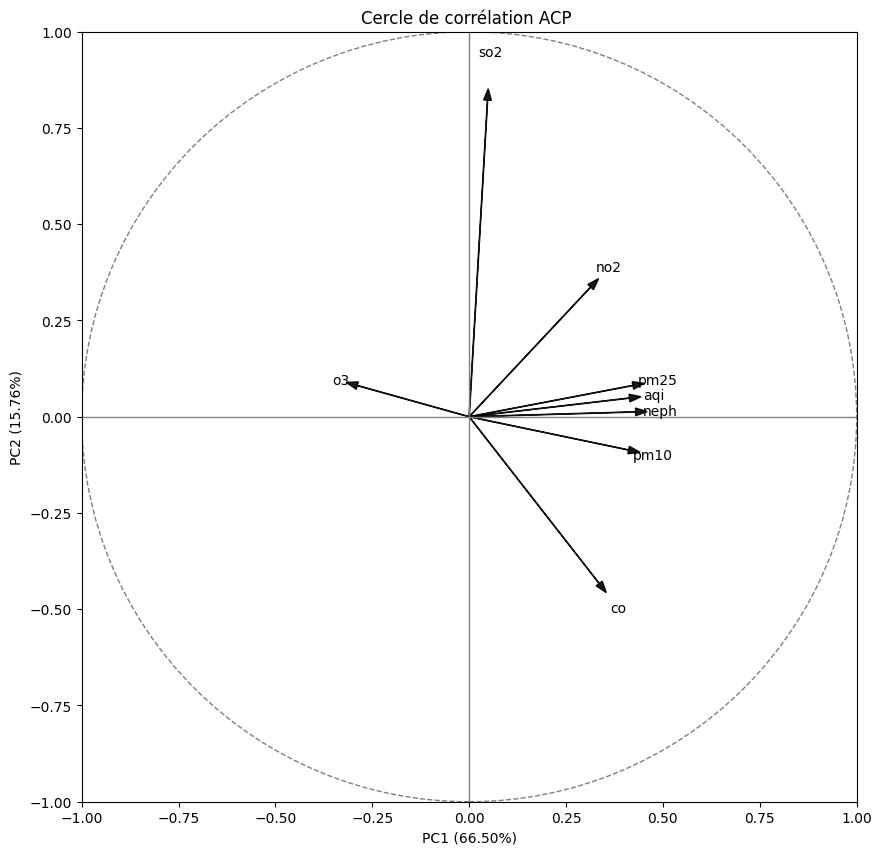

In [7]:
df_numeric = data.select_dtypes(include=[np.number])

# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

# Créer la figure
plt.figure(figsize=(10, 10))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, df_numeric.columns[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)

# Ajouter les pourcentages de variance expliquée sur les étiquettes des axes
plt.xlabel(f'PC1 ({explained_variance[0]:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2f}%)')
plt.title('Cercle de corrélation ACP')

plt.title('Cercle de corrélation ACP ')

# Afficher la figure
plt.show()

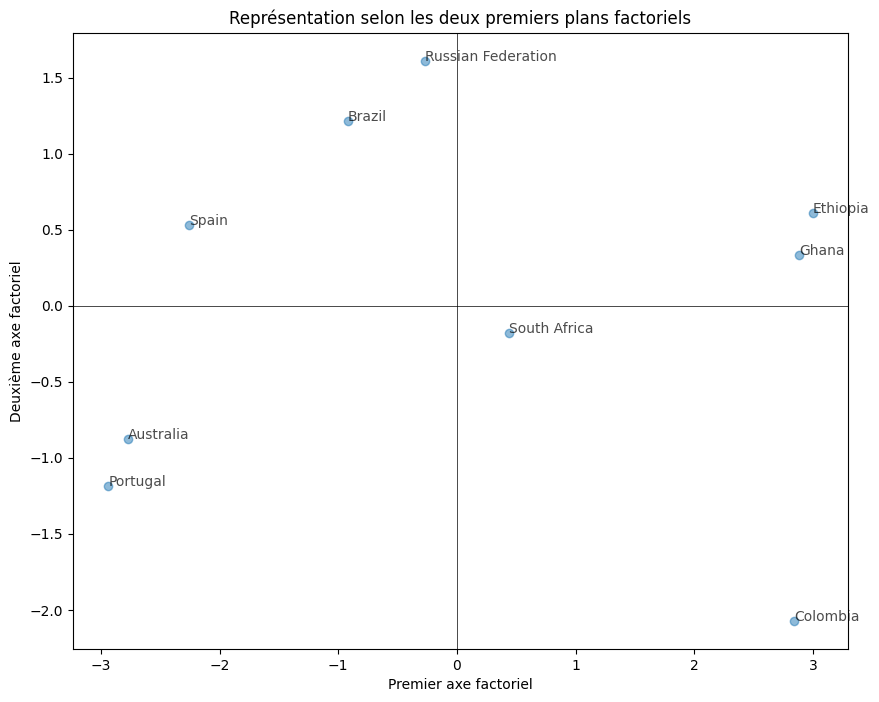

In [9]:
# Créer le graphique du premier plan factoriel
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.5)

# Ajouter des étiquettes pour chaque point (ville)
for i, city in enumerate(data['Country_Name'].unique()):
    ax.annotate(city, (df_pca[i, 0], df_pca[i, 1]), alpha=0.7)

# Ajouter des axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Labels des axes
ax.set_xlabel('Premier axe factoriel')
ax.set_ylabel('Deuxième axe factoriel')

# Titre du graphique
plt.title('Représentation selon les deux premiers plans factoriels')

# Afficher le graphique
plt.show()

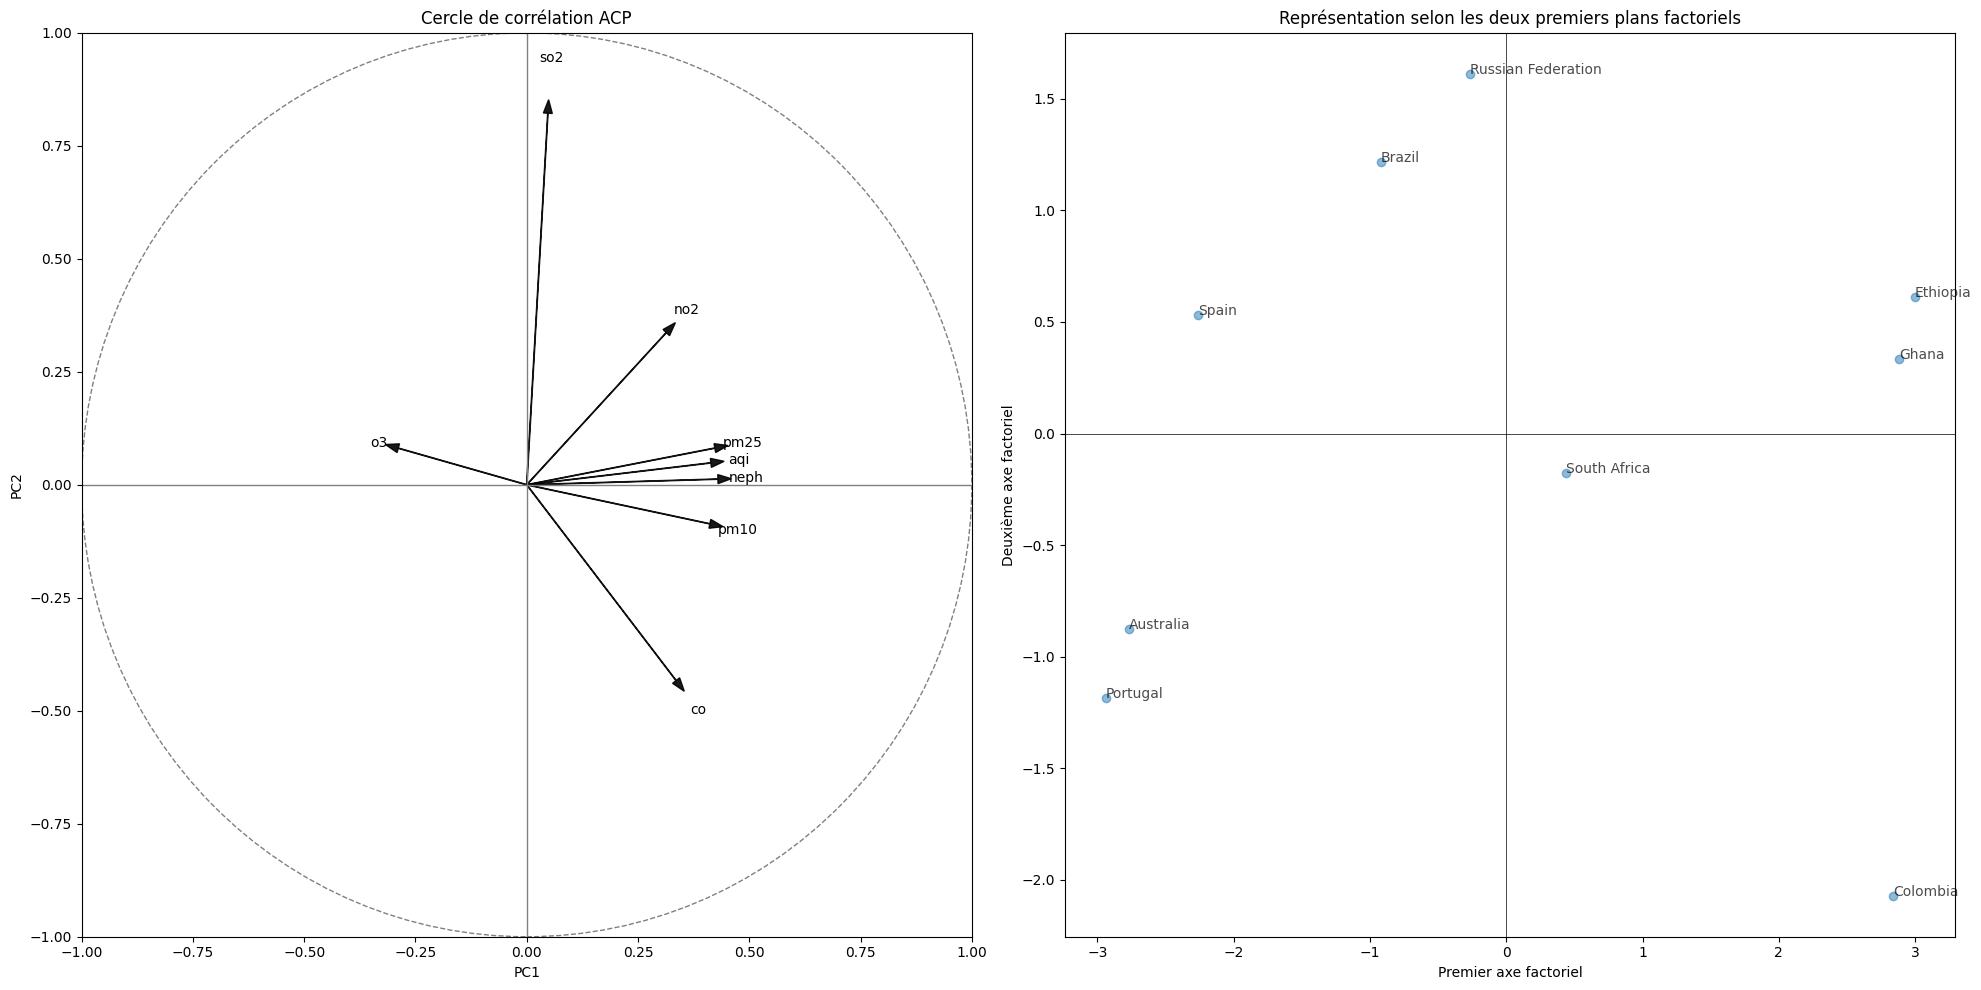

In [20]:
# Créer une figure avec deux sous-graphes côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Premier sous-graphe: Cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]

# Placer les vecteurs des variables
for i in range(n):
    ax1.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    ax1.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, numeric_columns[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
ax1.add_artist(circle)

# Ajuster les limites et les axes
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.axhline(0, color='gray', linewidth=1)
ax1.axvline(0, color='gray', linewidth=1)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Cercle de corrélation ACP')

# Deuxième sous-graphe: Premier plan factoriel
ax2.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.5)

# Ajouter des étiquettes pour chaque point (ville)
for i, city in enumerate(data['Country_Name'].unique()):
    ax2.annotate(city, (df_pca[i, 0], df_pca[i, 1]), alpha=0.7)

# Ajouter des axes
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='black', linewidth=0.5)

# Labels des axes
ax2.set_xlabel('Premier axe factoriel')
ax2.set_ylabel('Deuxième axe factoriel')
ax2.set_title('Représentation selon les deux premiers plans factoriels')

# Afficher la figure
plt.tight_layout()
plt.show()

In [22]:
# Déterminer le nombre optimal de clusters (facultatif, méthode elbow)
inertia = []
for n in range(1, 10):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(df_normalized)
    inertia.append(kmeans.inertia_)

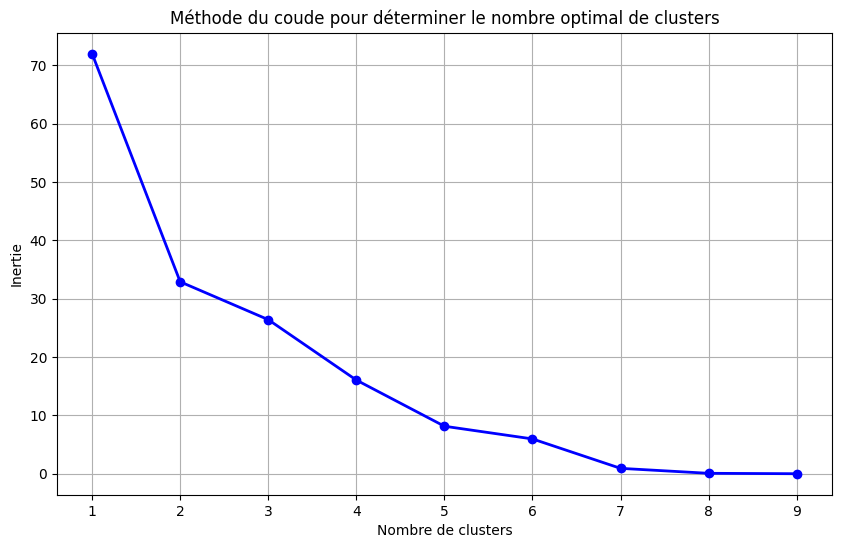

In [30]:
# Tracer la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o', color='blue', linestyle='-', linewidth=2)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.grid(True)
plt.show()

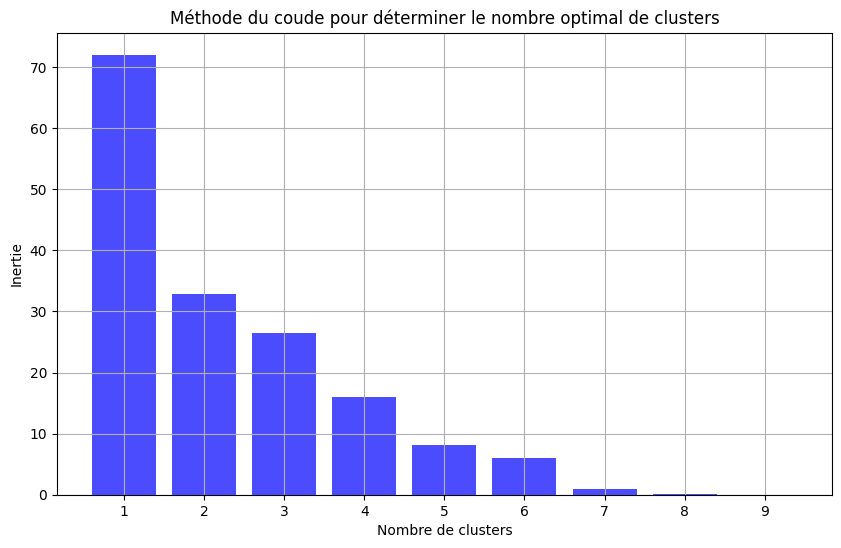

In [31]:
# Tracer la méthode du coude sous forme d'histogramme
plt.figure(figsize=(10, 6))
plt.bar(range(1, 10), inertia, color='blue', alpha=0.7)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xticks(range(1, 10))
plt.grid(True)
plt.show()

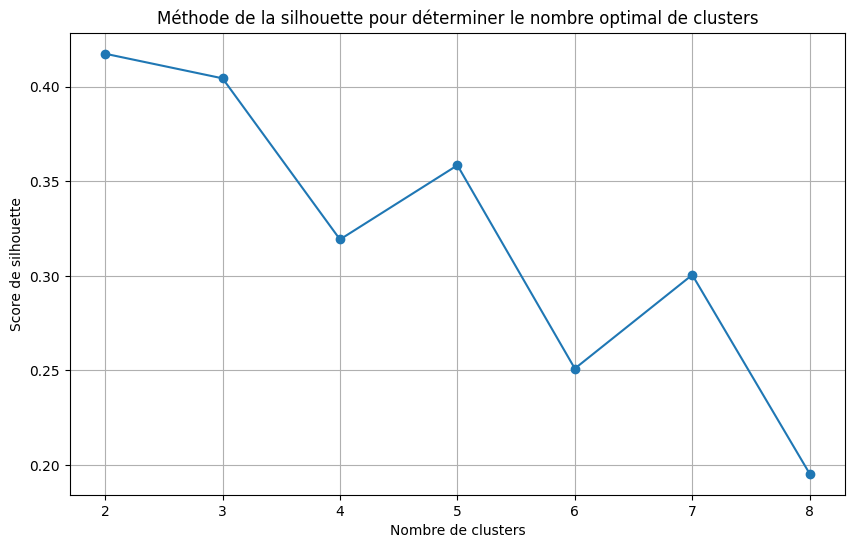

In [35]:
n_samples = df_normalized.shape[0]

# Liste pour stocker les scores de silhouette
silhouette_scores = []

# Choix du nombre de clusters à tester
min_clusters = 2
max_clusters = n_samples - 1  # max_clusters doit être inférieur à n_samples

# Calcul du score de silhouette pour chaque nombre de clusters
for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_normalized)
    silhouette_avg = silhouette_score(df_normalized, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Tracer le graphique du score de silhouette
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Méthode de la silhouette pour déterminer le nombre optimal de clusters')
plt.grid(True)
plt.show()

In [36]:
# Appliquer K-means avec un nombre de clusters choisi (par exemple, 3)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
agg_data['Cluster'] = kmeans.fit_predict(df_normalized)

# Afficher les différentes villes dans chaque cluster
for cluster in range(n_clusters):
    print(f"Cluster {cluster}:")
    print(agg_data[agg_data['Cluster'] == cluster]['Country_Name'].tolist())
    print("\n")

Cluster 0:
['Ethiopia', 'Colombia', 'Ghana']


Cluster 1:
['Australia', 'Spain', 'Portugal', 'South Africa', 'Russian Federation', 'Brazil']




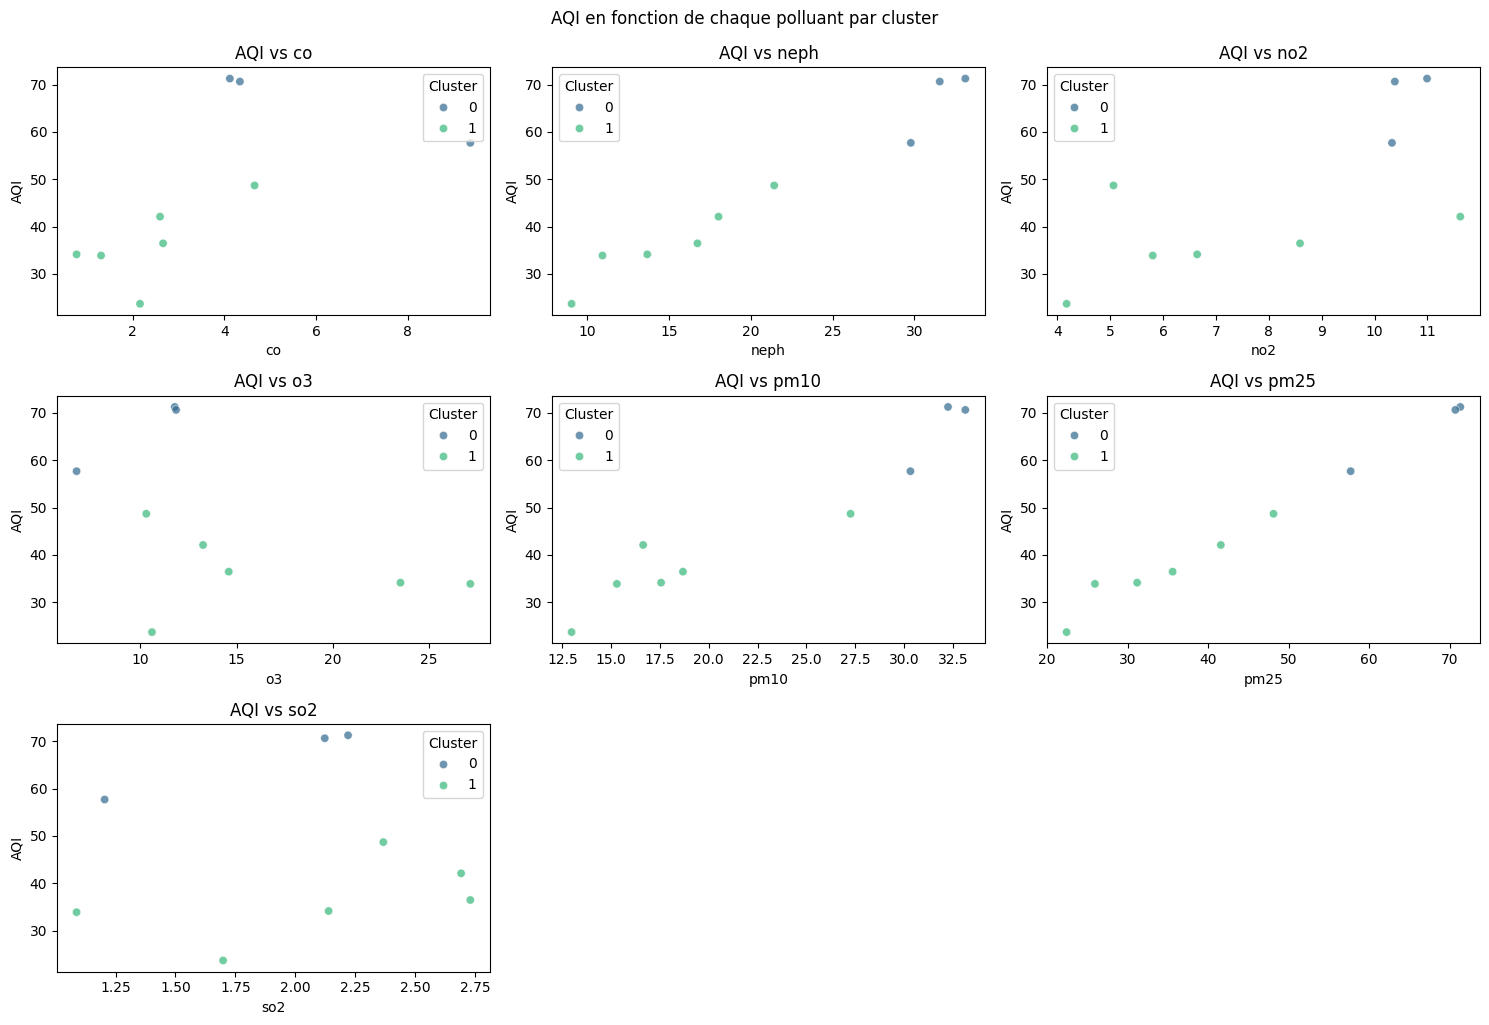

In [37]:
# Liste des polluants à examiner
pollutants = ['co', 'neph', 'no2', 'o3', 'pm10', 'pm25', 'so2']

# Création des graphiques de dispersion pour chaque polluant
plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(pollutants, start=1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=pollutant, y='aqi', data=agg_data, hue='Cluster', palette='viridis', alpha=0.7)
    plt.title(f'AQI vs {pollutant}')
    plt.xlabel(pollutant)
    plt.ylabel('AQI')
    plt.tight_layout()

# Ajustement global des sous-titres
plt.suptitle('AQI en fonction de chaque polluant par cluster', y=1.02)
plt.show()